Steps of the pipeline in this notebook:

1. Load raw data
2. Create preprocessed data
3. Get predictions of a model
4. Dimensionality reduction (U-MAP)
5. Find cluster of interest of FN in dimensionality reduction space
6. Plot the cluster of interest in raw data space

In [23]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import umap
from sklearn.neighbors import KDTree
from tqdm import tqdm

random_seed = 10
color_map = mcolors.ListedColormap(['blue', 'green', 'red', 'orange']) # TP, TN, FP, FN

In [24]:
# 1. Load raw data

def load_all_partitions(directory):
    all_files = glob.glob(os.path.join(directory, '*.csv'))
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

x_raw = load_all_partitions('data/AF-Raw-Data/AF Data/all_raw_data_csv')

# Remove rows that are duplicates or have values > 1800
n_before = x_raw.shape[0]
x_raw = x_raw.drop_duplicates()
x_raw = x_raw[(x_raw.T < 1800).all()]
print(f"Removed {n_before - x_raw.shape[0]} rows with values > 1800 or are duplicate")

# Balance the dataset, by taking the same number of samples from each class
class_1 = x_raw[x_raw['Class_Label'] == 1]
class_0 = x_raw[x_raw['Class_Label'] == 0].sample(len(class_1), random_state=random_seed)
x_raw = pd.concat([class_1, class_0])
print(f"Balanced dataset: {x_raw.shape[0]} samples in total")

x_raw.reset_index(drop=True, inplace=True)
x_raw['Sample_id'] = x_raw.index

# Split the class label from the features and split the data into train and test
y_raw = x_raw[['Class_Label', 'Sample_id']]
x_raw = x_raw.drop(columns=['Class_Label'])
x_raw_train, x_raw_test, y_train, y_test = train_test_split(x_raw, y_raw, test_size=0.2, random_state=random_seed)


Removed 136070 rows with values > 1800 or are duplicate
Balanced dataset: 109272 samples in total


In [25]:
# 2. Create preprocessed data

# 30 bins (of 50 milliseconds) are created covering R-R intervals of 200 ms up to 1700 ms. For each
#sample the frequency of an R-R interval occurring in a certain bin was counted.

# Function to bin and count intervals for a row
def bin_row(row, bin_edges):
    intervals = row[:-1].values # Exclude the class label from binning
    bin_indices = np.digitize(intervals, bins=bin_edges, right=False)
    bin_counts = np.bincount(bin_indices, minlength=len(bin_edges)+1)[1:-1]  # Exclude counts outside defined bins
    return bin_counts

bin_edges = np.arange(200, 1751, 50) #ms
bin_column_names = [f'bin_{i + 1}' for i in range(len(bin_edges) - 1)]

def preprocess_into_bins(x_data):
    x_bins = x_data.apply(lambda row: bin_row(row, bin_edges), axis=1, result_type='expand')
    x_bins.columns = bin_column_names
    x_bins['Sample_id'] = x_data['Sample_id']
    return x_bins

x_bins_train = preprocess_into_bins(x_raw_train)
x_bins_test = preprocess_into_bins(x_raw_test)
x_bins = pd.concat([x_bins_train, x_bins_test], ignore_index=True)
x_bins = x_bins.sort_values('Sample_id')


In [39]:
# 3. Get predictions of a model

# Normalise using standard scaler
scaler = StandardScaler()
x_bins_train_scaled = scaler.fit_transform(x_bins_train[bin_column_names])
x_bins_test_scaled = scaler.transform(x_bins_test[bin_column_names])

svm = SVC(random_state=random_seed, kernel='rbf') #possible kernels: 'linear', 'poly', 'rbf', 'sigmoid'
svm.fit(x_bins_train_scaled, y_train['Class_Label'])

SVC(random_state=10)

In [40]:
y_pred_test = svm.predict(x_bins_test_scaled)
y_pred_train = svm.predict(x_bins_train_scaled)

acc_test_svm = accuracy_score(y_test['Class_Label'], y_pred_test)
f1_test_svm = f1_score(y_test['Class_Label'], y_pred_test)

acc_train_svm = accuracy_score(y_train['Class_Label'], y_pred_train)
f1_train_svm = f1_score(y_train['Class_Label'], y_pred_train)

print(f"Test accuracy: {round(acc_test_svm, 4)}, F1: {round(f1_test_svm, 4)}")
print(f"Train accuracy: {round(acc_train_svm, 4)}, F1: {round(f1_train_svm, 4)}")

Test accuracy: 0.953, F1: 0.9531
Train accuracy: 0.9538, F1: 0.954


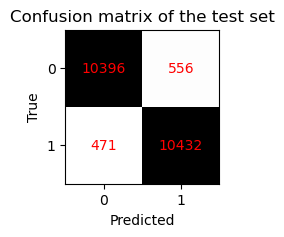

In [41]:
cm_test = confusion_matrix(y_test['Class_Label'], y_pred_test)
#visualise it nicely
plt.figure(figsize=(2, 2))
plt.imshow(cm_test, cmap='binary')
plt.grid(False)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_test[i, j], ha='center', va='center', color='red')
plt.ylabel('True'), plt.xlabel('Predicted'), plt.xticks([0, 1], ['0', '1']), plt.yticks([0, 1], ['0', '1'])
plt.title('Confusion matrix of the test set')
plt.show()

In [42]:
# To the test set, add the predictions of the model
x_bins_test['Prediction'] = y_pred_test
x_bins_train['Prediction'] = y_pred_train
x_bins_test['Class_Label'] = y_test['Class_Label']
x_bins_train['Class_Label'] = y_train['Class_Label']

def add_col_cm_label(x_df):
    # Add a column indicating TP, TN, FP, FN, name the column 'CM_Label'
    x_df['CM_Label'] = ''
    x_df.loc[(x_df['Prediction'] == 1) & (x_df['Class_Label'] == 1), 'CM_Label'] = 'TP'
    x_df.loc[(x_df['Prediction'] == 0) & (x_df['Class_Label'] == 0), 'CM_Label'] = 'TN'
    x_df.loc[(x_df['Prediction'] == 1) & (x_df['Class_Label'] == 0), 'CM_Label'] = 'FP'
    x_df.loc[(x_df['Prediction'] == 0) & (x_df['Class_Label'] == 1), 'CM_Label'] = 'FN'
    return x_df
    
x_bins_test = add_col_cm_label(x_bins_test)
x_bins_train = add_col_cm_label(x_bins_train)

1.0


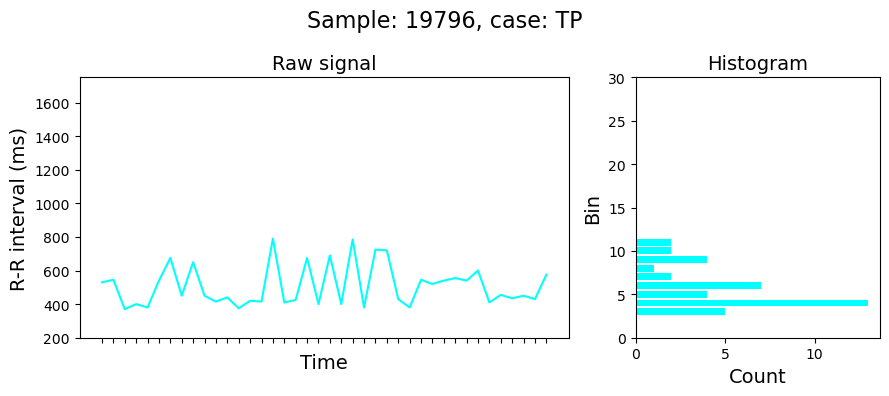

In [43]:
# Plot a sample

def plot_sample(sample_id, color_case ='cyan'):
    sample_raw = x_raw_test[x_raw_test['Sample_id'] == sample_id]
    sample_bin = x_bins_test[x_bins_test['Sample_id'] == sample_id]
    sample_pred = sample_bin['Prediction'].values[0]
    sample_gt = sample_bin['Class_Label'].values[0]
    sample_cm_label = sample_bin['CM_Label'].values[0]
    print(sample_gt)
    
    fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [2, 1]})
    fig.suptitle(f'Sample: {sample_id}, case: {sample_cm_label}', fontsize=16)
    #fig.suptitle(f'Random sample, ground truth = no-AF' , fontsize=16)
    
    # Plot the raw data
    axs[0].plot(sample_raw.iloc[0][:-1], color=color_case)
    axs[0].set_title(f"Raw signal", fontsize=14)
    axs[0].set_xlabel("Time", fontsize=14)
    axs[0].set_ylabel("R-R interval (ms)", fontsize=14)
    axs[0].set_xticklabels([])
    axs[0].set_ylim(200, 1750)

    axs[1].barh(range(0, 31), sample_bin[bin_column_names].values[0], color=color_case)
    axs[1].set_title(f"Histogram", fontsize=14)
    axs[1].set_xlabel("Count", fontsize=14)
    axs[1].set_ylabel("Bin", fontsize=14)
    axs[1].set_ylim(0, 30)
    
    plt.tight_layout()
    #save the figure
    #plt.savefig(f'images/example_sample_no-AF.png')
    plt.show()
    
plot_sample(19796)#, color_case = 'red')
#sample_id_no_AF = x_bins_test[x_bins_test['Class_Label'] == 0].sample(1)['Sample_id'].values[0]
#plot_sample(sample_id_no_AF, color_case = 'green')


In [44]:
# 4. Dimensionality reduction (U-MAP)
markers = ['o', 'o', 'x', 'x'] # TP, TN, FP, FN

# It seems that including both the train and test set (meaning all data) in the U-MAP doens't really change much 

# Apply UMAP on the test set
umap_model = umap.UMAP(n_neighbors=20, min_dist=0.9)#, random_state=random_seed)
sampling_percentage = 0.20
all_data_umap = umap_model.fit_transform(x_bins[bin_column_names].sample(frac=sampling_percentage, random_state=random_seed))

test_result_umap = umap_model.transform(x_bins_test[bin_column_names]) #TODO: ask if we should use the train set as well or only test set? maybe only train set to avoid data leakage?
train_result_umap = umap_model.transform(x_bins_train[bin_column_names])

x_bins_test['UMAP_1'] = test_result_umap[:, 0] 
x_bins_test['UMAP_2'] = test_result_umap[:, 1]
x_bins_train['UMAP_1'] = train_result_umap[:, 0]
x_bins_train['UMAP_2'] = train_result_umap[:, 1]

C:\Users\gijsd\anaconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


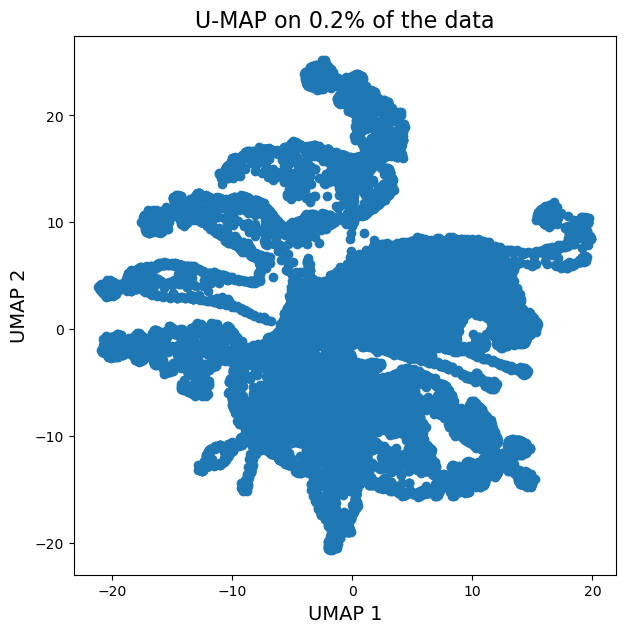

In [45]:
#visualize the U-MAP (using all_data_umap)

plt.figure(figsize=(7, 7))
plt.title(f'U-MAP on {sampling_percentage}% of the data', fontsize=16)
plt.scatter(all_data_umap[:, 0], all_data_umap[:, 1])
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.show()

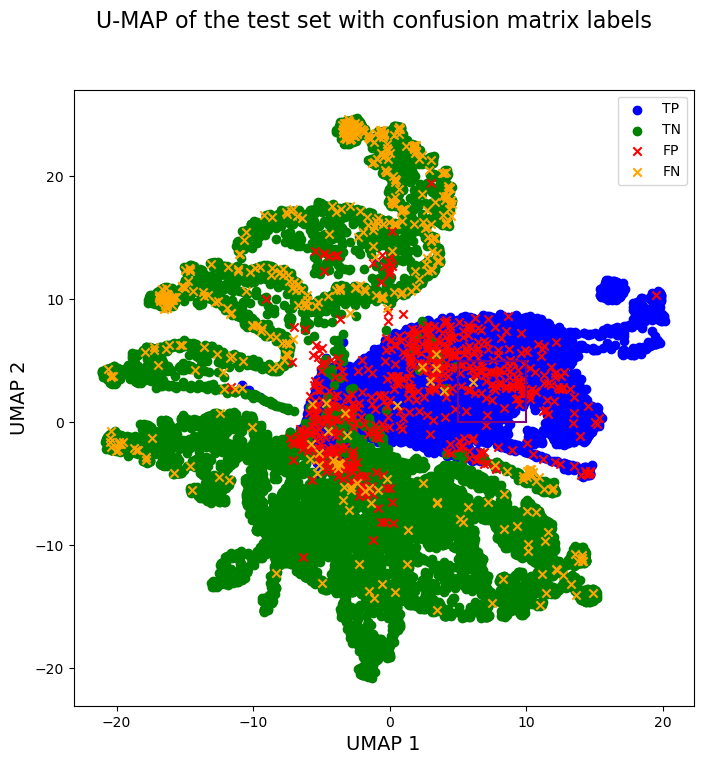

In [46]:
# Plot the U-MAP with the confusion matrix labels
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle('U-MAP of the test set with confusion matrix labels', fontsize=16)

for i, cm_label in enumerate(['TP', 'TN', 'FP', 'FN']):
    cm_data = x_bins_test[x_bins_test['CM_Label'] == cm_label]
    ax.scatter(cm_data['UMAP_1'], cm_data['UMAP_2'], c=color_map.colors[i], marker=markers[i], label=cm_label)
    
ax.set_xlabel('UMAP 1', fontsize=14)
ax.set_ylabel('UMAP 2', fontsize=14)
ax.legend()


# plot a square box around the cluster of interest
## IMPORTANT, LOWER BOUND FIRST THEN UPPER BOUND
cluster_x = [5, 10] # U-Map 1 bounds
cluster_y = [0, 5] # U-Map 2 bounds 
box_color = 'purple'
ax.plot([cluster_x[0], cluster_x[0]], [cluster_y[0], cluster_y[1]], c=box_color)
ax.plot([cluster_x[1], cluster_x[1]], [cluster_y[0], cluster_y[1]], c=box_color)
ax.plot([cluster_x[0], cluster_x[1]], [cluster_y[0], cluster_y[0]], c=box_color)
ax.plot([cluster_x[0], cluster_x[1]], [cluster_y[1], cluster_y[1]], c=box_color)
plt.show()


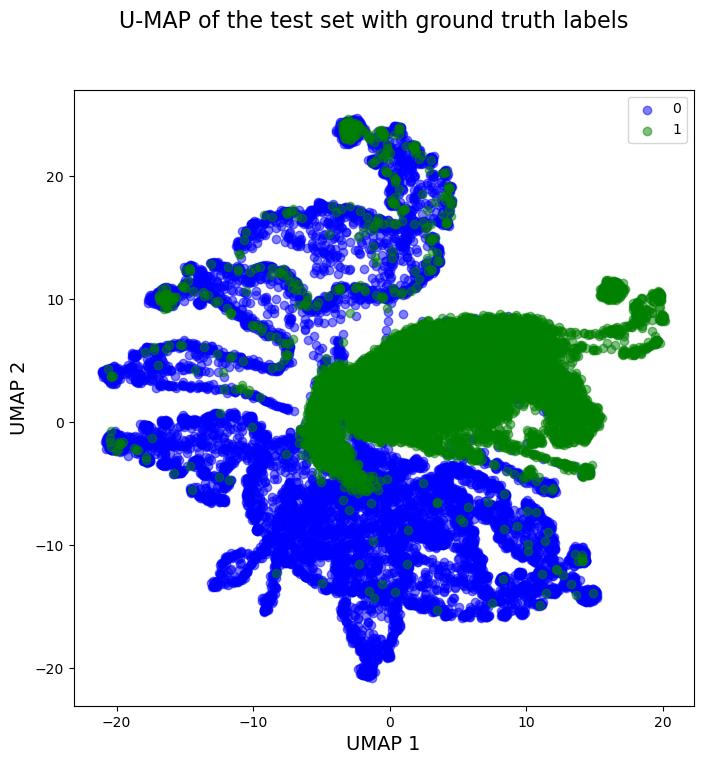

In [47]:
# Plot the U-MAP with the ground truth label
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle('U-MAP of the test set with ground truth labels', fontsize=16)

for i, class_label in enumerate([0, 1]):
    class_data = x_bins_test[x_bins_test['Class_Label'] == class_label]
    ax.scatter(class_data['UMAP_1'], class_data['UMAP_2'], c=color_map.colors[i], label=class_label, alpha=0.5)
    
ax.set_xlabel('UMAP 1', fontsize=14)
ax.set_ylabel('UMAP 2', fontsize=14)
ax.legend()


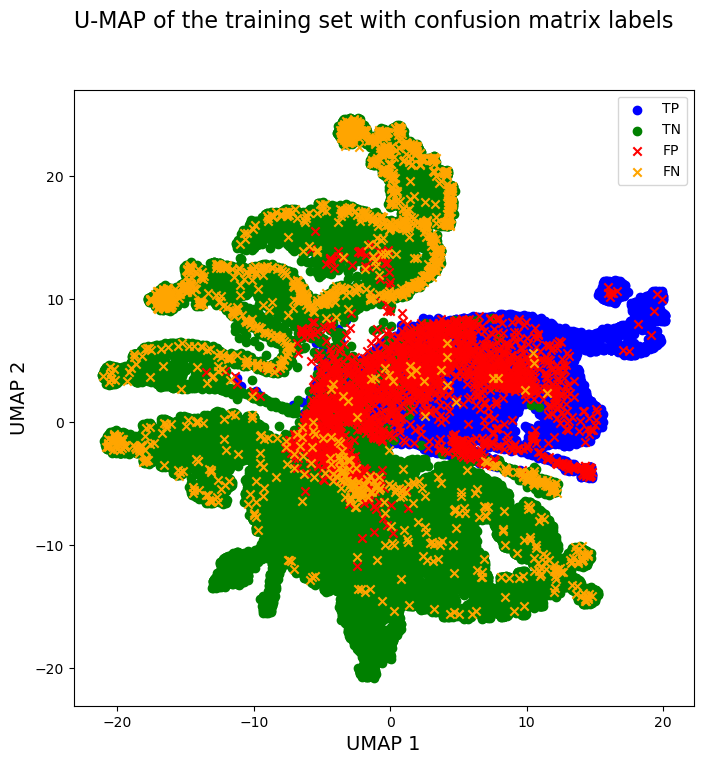

In [48]:
# Plot the U-MAP for the training set (optional)
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle('U-MAP of the training set with confusion matrix labels', fontsize=16)

for i, cm_label in enumerate(['TP', 'TN', 'FP', 'FN']):
    cm_data = x_bins_train[x_bins_train['CM_Label'] == cm_label]
    ax.scatter(cm_data['UMAP_1'], cm_data['UMAP_2'], c=color_map.colors[i], marker=markers[i], label=cm_label)
    
ax.set_xlabel('UMAP 1', fontsize=14)
ax.set_ylabel('UMAP 2', fontsize=14)
ax.legend()


In [49]:
# From inside the cluster box (in the test data plot), sample the following CM_labels
cluster_samples = x_bins_test[(x_bins_test['UMAP_1'] > cluster_x[0]) & (x_bins_test['UMAP_1'] < cluster_x[1]) & (x_bins_test['UMAP_2'] > cluster_y[0]) & (x_bins_test['UMAP_2'] < cluster_y[1])]
cluster_samples['CM_Label'].value_counts() #interesting to see the distribution of the CM labels

#color_map = mcolors.ListedColormap(['blue', 'green', 'red', 'orange']) # TP, TN, FP, FN

#sample each case from the cluster
#fn_sample_id = cluster_samples[cluster_samples['CM_Label'] == 'FN'].sample(1)['Sample_id'].values[0]
#tn_sample_id = cluster_samples[cluster_samples['CM_Label'] == 'TN'].sample(1)['Sample_id'].values[0]
#tp_sample_id = cluster_samples[cluster_samples['CM_Label'] == 'TP'].sample(1)['Sample_id'].values[0]
#fp_sample_id = cluster_samples[cluster_samples['CM_Label'] == 'FP'].sample(1)['Sample_id'].values[0]

#plot_sample(fn_sample_id, color_case = 'red')
#plot_sample(tn_sample_id, color_case = 'green')
#plot_sample(tp_sample_id, color_case = 'blue')
#plot_sample(fp_sample_id, color_case = 'orange')


TP    1409
FP      63
FN       1
Name: CM_Label, dtype: int64

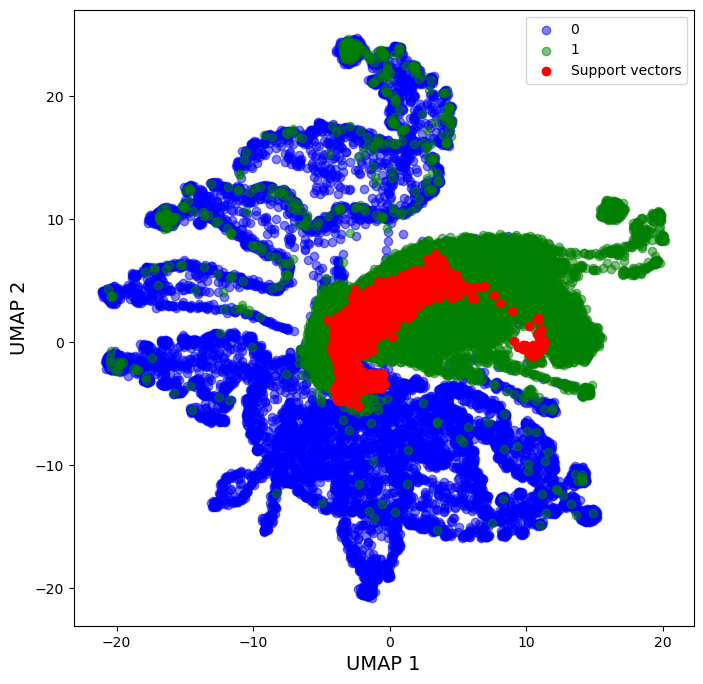

In [50]:
#get the support vectors
support_vectors = svm.support_vectors_
support_vectors_umap = umap_model.transform(support_vectors)

#plot the support vectors
plt.figure(figsize=(8, 8))
for i, class_label in enumerate([0, 1]):
    class_data = x_bins_test[x_bins_test['Class_Label'] == class_label]
    plt.scatter(class_data['UMAP_1'], class_data['UMAP_2'], c=color_map.colors[i], label=class_label, alpha=0.5)
plt.scatter(support_vectors_umap[:, 0], support_vectors_umap[:, 1], color='red', label='Support vectors')
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.legend()
plt.show()


N2-metric

In [ ]:
#TODO: ask teacher for follow up steps
# I can think of the following: get "distance"/difference metric between the samples of different cases in the cluster
# That is useful to know how good the dimensionality reduction is to putting similar points together

# Might as well still be AF, since doctors look at ECG, cannot derive concrete conclusion
# Use the pipeline to select qualitatively interesting samples
#CO-12 contrastivity y
# used to explain why the model does not have full accuracy
# the model is good, see confusion matrix, but visually it can be deceiving

#TODO: plot some af episodes from the raw data (the full ones, to see how these sliding windows appear)
# the following would require investigation into the raw data, by creating new dataset from TS_procces.ipynb with an extra column
#--> might reveal pauses in the same AF epsidoe
#--> might reveal that some AF episodes are not clear at all (meaning r-r interval looks normal and doctors saw something else in ecg)
#TODO: N2 as co-12! (contrastivity)
#TODO: save raw data with links to data-file names and timestamp so we can inspect the raw data

In [ ]:
def get_nearest_neighbour_distance(tree, point, exclude_point):
    point = point.reshape(1, -1)
    dist, idx = tree.query(point, k=2)

    if exclude_point:
        dist = dist[0][1]  # Take the second nearest neighbor distance
    else:
        dist = dist[0][0] # Take the nearest neighbor distance
    return dist

def get_N2(x):
    x.reset_index(drop=True, inplace=True)
    # Prepare KD-trees for both classes
    class_0_points = x[x['Class_Label'] == 0].iloc[:, :-1].values
    class_1_points = x[x['Class_Label'] == 1].iloc[:, :-1].values
    
    tree_class_0 = KDTree(class_0_points)
    tree_class_1 = KDTree(class_1_points)

    # N2 = \sum \delta(point, nearest neighbour of the same class) / \sum \delta(point, nearest neighbour of the different class)
    sum_same = 0
    sum_diff = 0

    for i in tqdm(range(len(x)), desc="Calculating N2"):
        point = x.iloc[i, :-1].values
        gt = x.iloc[i, -1]
        
        if gt == 0:
            sum_same += get_nearest_neighbour_distance(tree_class_0, point, True)
            sum_diff += get_nearest_neighbour_distance(tree_class_1, point, False)
        else:
            sum_same += get_nearest_neighbour_distance(tree_class_1, point, True)
            sum_diff += get_nearest_neighbour_distance(tree_class_0, point, False)

    N2 = sum_same / sum_diff

    return N2

In [ ]:
#calculate N2 for the U-MAP
N2_test = get_N2(x_bins_test[['UMAP_1', 'UMAP_2', 'Class_Label']])
print(f"N2 for the U-MAP of the test set: {N2_test}")

In [ ]:
#calculate N2 for the raw data
x_raw['Class_Label'] = y_raw['Class_Label']
N2_raw = get_N2(x_raw.drop(columns=['Sample_id']).sample(30000))
print(f"N2 for the raw data: {N2_raw}")

In [ ]:
# calculate N2 for binned data
N2_bins_test = get_N2(x_bins_test.drop(columns=['Sample_id', 'CM_Label', 'Prediction', 'UMAP_1', 'UMAP_2']))
print(f"N2 for the binned data of the test set: {N2_bins_test}")

In [ ]:
# RAW (40D): 0.84
# BIN (30D): 0.38
# U-MAP (2D): 0.13
#lower is better seperability of classes
# for data-centric XAI and co-12 property contrastivity, one could investigate how the N2 metric changes when improving the data quality

In [ ]:
# Calculate Fisher's Discriminant Ratio for each feature
def fisher_discriminant_ratio(df, class_col):
    features = df.columns[df.columns != class_col]
    class_labels = df[class_col].unique()

    class_1 = df[df[class_col] == class_labels[0]]
    class_2 = df[df[class_col] == class_labels[1]]

    f_ratios = []
    for feature in features:
        mu1, mu2 = class_1[feature].mean(), class_2[feature].mean()
        sigma1, sigma2 = class_1[feature].var(), class_2[feature].var()
        f_ratio = (mu1 - mu2)**2 / (sigma1 + sigma2)
        f_ratios.append(f_ratio)

    return max(f_ratios)

# Calculate the maximum Fisher's Discriminant Ratio
max_f_ratio = fisher_discriminant_ratio(x_bins_train.drop(columns=['Sample_id', 'CM_Label', 'Prediction', 'UMAP_1', 'UMAP_2']), 'Class_Label')
print("Maximum Fisher's Discriminant Ratio (F1):", max_f_ratio)